In [6]:
# Imports and setup
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from icwaves.data.loading import get_feature_extractor, load_data_bundles
from icwaves.evaluation.config import EvalConfig
from icwaves.evaluation.evaluation import (
    eval_classifier_per_subject_brain_F1, load_classifier)
from icwaves.evaluation.iclabel import calculate_iclabel_f1_scores
from icwaves.viz import plot_line_with_error_area

In [ ]:
validation_times = np.r_[
    [9.0, 19.5, 30.0, 39.0, 49.5, 60],
    np.arange(2 * 60, 5 * 60 + 1, 60),
    np.arange(5 * 60, 5 * 60 + 1, 60),
    np.arange(10 * 60, 50 * 60 + 1, 5 * 60),
].astype(float)
root = Path().resolve().parent
mean_std_df = {}
feature_extractor = {}
clf = {}
train_seg_len = {}
agg_method = {}
feature_extractor_str = "bowav_psd_autocorr"
classifier_type = "ensembled_logistic"
for eval_dataset in ["cue", "emotion_study"]:
    mean_std_df[eval_dataset] = {}
    mean_std_df[eval_dataset][feature_extractor_str] = {}
    # Configuration
    config = EvalConfig(
        eval_dataset=eval_dataset,
        feature_extractor=feature_extractor_str,
        classifier_type=classifier_type,
        validation_segment_length=300,
        root=root,
    )
    # Load data
    print(
        f"Getting data from {eval_dataset}, and building feature extractor for {feature_extractor_str}..."
    )
    data_bundles = load_data_bundles(config)
    feature_extractor["bowav"] = get_feature_extractor("bowav", data_bundles)
    feature_extractor["psd_autocorr"] = get_feature_extractor(
        "psd_autocorr", data_bundles
    )
    mean_std_df[eval_dataset][feature_extractor_str][classifier_type] = {}
    for validation_segment_len in [300, -1]:
        config.validation_segment_length = validation_segment_len
        print(
            f"Validation segment length: {validation_segment_len} | classifier type: {classifier_type}"
        )

        # Load bowav classifier
        clf["bowav"], _best_params = load_classifier(config.path_to_classifier["bowav"])
        train_seg_len.update(_best_params["training_segment_length"])
        agg_method["bowav"] = _best_params["input_or_output_aggregation_method"]

        # Load psd_autocorr classifier
        clf["psd_autocorr"], _best_params = load_classifier(
            config.path_to_classifier["psd_autocorr"]
        )
        train_seg_len.update(_best_params["training_segment_length"])
        agg_method["psd_autocorr"] = _best_params["input_or_output_aggregation_method"]
        # TODO: make this cleaner
        # for 'psd_autocorr', the training segment length is in samples. Since the sampling rate
        # for 'emotion' and 'cue' are 256 Hz and 500 Hz, resp., we need to convert that length
        # (the model was trained on 'emotion')
        if eval_dataset == "cue":
            train_seg_len["psd_autocorr"] = int(
                train_seg_len["psd_autocorr"] / 256 * 500
            )

        # Evaluate
        print("Computing F1 score...")
        mean_std_df[eval_dataset][feature_extractor_str][classifier_type][
            validation_segment_len
        ] = eval_classifier_per_subject_brain_F1(
            config,
            clf,
            feature_extractor,
            validation_times,
            data_bundles,
            agg_method,
            train_seg_len,
        )

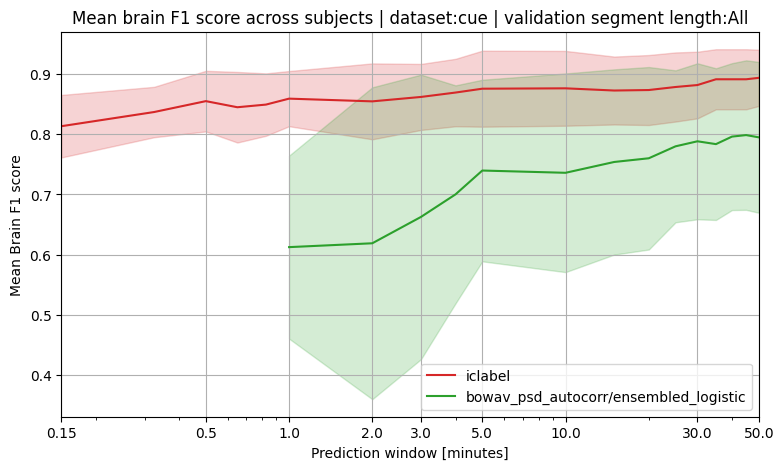

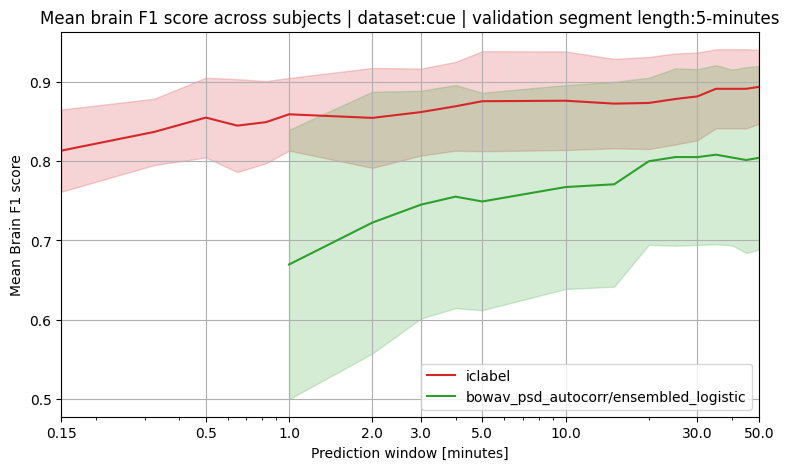

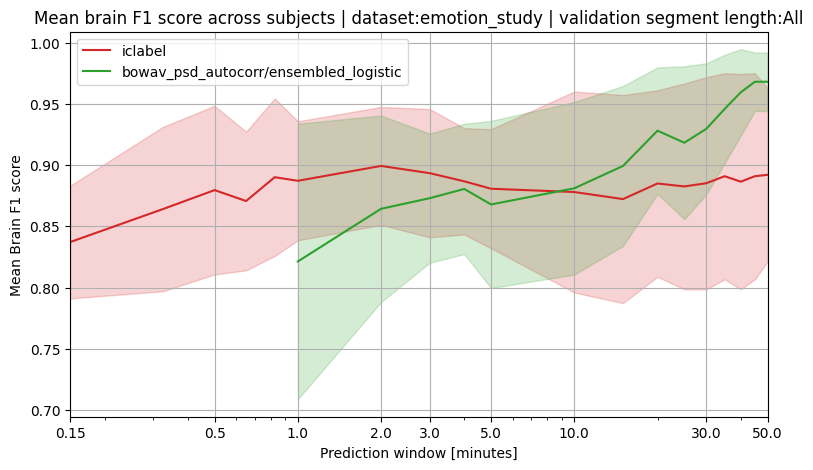

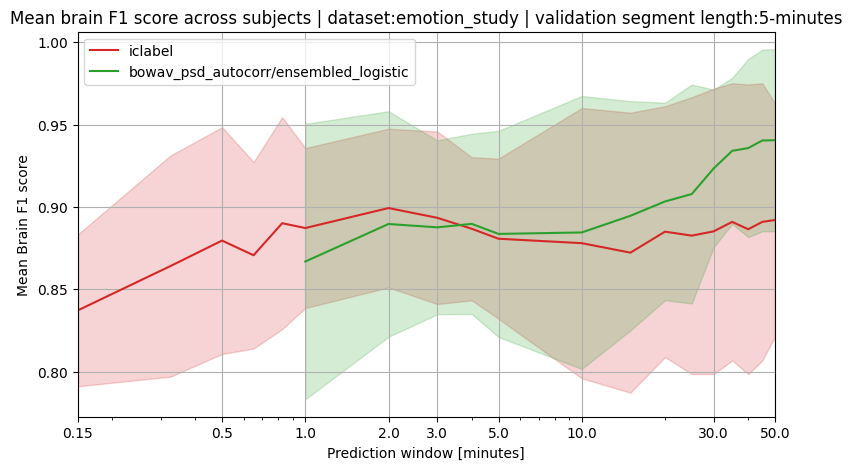

In [8]:
global_x_ticks = np.array([0.15, 0.5, 1, 2, 3, 5, 10, 30, 50])
# colors = {"bowav/logistic": "blue", "psd_autocorr/logistic": "green", "bowav/random_forest": "orange", "psd_autocorr/random_forest": "purple"}
colors = {
    "bowav_psd_autocorr/ensembled_logistic": "green",
}
val_seg_len_map = {-1: "All", 300: "5-minutes"}
# The *.mat files with the ICLabel labels were manually created for the following prediction times
#     9.0,    19.5,    30.0,    39.0,    49.5
#    60.0,   120.0,   180.0,   240.0,   300.0
#   300.0,   600.0,   900.0,  1200.0,  1500.0
#  1800.0,  2100.0,  2400.0,  2700.0,  3000.0
validation_times_ = 1.5 * (validation_times // 1.5)
for eval_dataset in ["cue", "emotion_study"]:
    # For ICLabel, the values for feature_extractor, classifier_type, train_dataset, and validation_segment_length
    # don't matter, as they are not used.
    config = EvalConfig(
        eval_dataset=eval_dataset,
        feature_extractor="bowav",
        classifier_type="logistic",
        validation_segment_length=-1,
        root=root,
    )
    iclabel_df = calculate_iclabel_f1_scores(config, validation_times_)
    iclabel_df = iclabel_df.rename(
        columns={
            "Brain F1 score - iclabel": "iclabel",
        }
    )

    for validation_segment_len in [-1, 300]:
        fig, ax = plt.subplots(figsize=(9, 5))
        ax = plot_line_with_error_area(
            ax,
            iclabel_df,
            "Prediction window [minutes]",
            "iclabel",
            "StdDev - iclabel",
            color="red",
        )

        df = mean_std_df[eval_dataset][feature_extractor_str][classifier_type][
            validation_segment_len
        ]
        # rename columns to also include the classifier type (e.g., "Brain F1 score - bowav" -> "Brain F1 score - bowav-logistic")
        df = df.rename(
            columns={
                "Brain F1 score - "
                + feature_extractor_str: f"{feature_extractor_str}/{classifier_type}",
                "StdDev - "
                + feature_extractor_str: f"StdDev - {feature_extractor_str}/{classifier_type}",
            }
        )
        ax = plot_line_with_error_area(
            ax,
            df,
            "Prediction window [minutes]",
            f"{feature_extractor_str}/{classifier_type}",
            f"StdDev - {feature_extractor_str}/{classifier_type}",
            color=colors[f"{feature_extractor_str}/{classifier_type}"],
        )

        ax.set_xscale("log")
        ax.set_xticks(global_x_ticks, labels=global_x_ticks)
        ax.set_xlim(global_x_ticks[0], 50)
        ax.set_xlabel("Prediction window [minutes]")
        ax.set_ylabel("Mean Brain F1 score")
        ax.set_title(
            f"Mean brain F1 score across subjects | dataset:{eval_dataset} | validation segment length:{val_seg_len_map[validation_segment_len]}"
        )
        ax.legend()
        ax.grid(True)
